# Prior Beliefs to Posterior Estimates

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pymc-labs/ai_decision_workshop/blob/main/notebooks/01_prior_and_posterior.ipynb)

In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm

plt.rcParams['figure.dpi'] = 75
plt.rcParams['figure.figsize'] = (6.4, 3.2)

In [2]:
def plot_prior(trace):
    return az.plot_posterior(trace, group='prior')

## The Beta-Binomial Model

In digital marketing, A/B testing is used to evaluate the effect of different versions of an ad, web page, etc. 
More generally, it has the same structure as tests of medical treatments, public policy interventions, product design, and more.

As an example, suppose we test an email campaign that includes a promotional offer.
We send version A to 100 people, and 8 of them accept the offer.
So the observed conversion rate in this sample is 8%.

Here's a dictionary that represents the results.

In [3]:
A = dict(n=100, k=8)

Some questions we'd like to answer:

* What is the probability someone responds to this email?
* How confident are we about that estimate?
* If we send the same email to 100 people, how many will respond?

And if we have more than one version of the email, we want to compare them.

To answer these questions, we'll use the beta-binomial model:

* A beta distribution to represent what we believe about the conversion rate.
* A binomial to represent the distribution of outcomes (number of responses).

Here's the beta distribution we'll use as a prior.

In [4]:
from scipy.stats import beta

beta_dist = beta(2, 5)
beta_dist.mean(), beta_dist.std()

(np.float64(0.2857142857142857), np.float64(0.15971914124998499))

In [5]:
qs = np.linspace(0, 1)
pdf = beta_dist.pdf(qs)

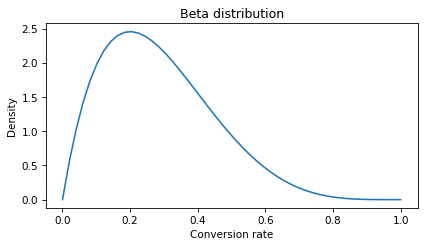

In [6]:
plt.plot(qs, pdf)
plt.xlabel('Conversion rate')
plt.ylabel('Density')
plt.title('Beta distribution');

With these parameters, the mean is about `0.28`, which means we think a typical response rate is about 28%.
But the width of the distribution indicates that we are very unsure about that.

Now let's pick an arbitrary single value from that distribution, `0.2`, and suppose we send 50 emails with that response rate.
The binomial distribution shows how many responses we should expect.

In [7]:
from scipy.stats import binom

binomial_dist = binom(n=50, p=0.2)
binomial_dist.mean()

np.float64(10.0)

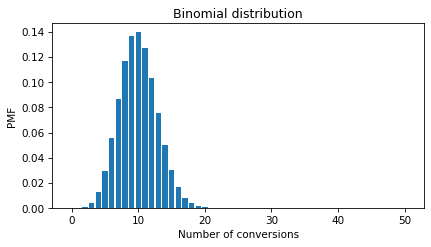

In [8]:
ks = np.arange(51)
pmf = binomial_dist.pmf(ks)
plt.bar(ks, pmf)
plt.xlabel('Number of conversions')
plt.ylabel('PMF')
plt.title('Binomial distribution');

The mean is 10, but values as low as 2 and as high as 20 have non-negligible probability.

In general we don't know the response rate -- we have to estimate it from data.

## The Bayesian Update

The fundamental idea in Bayesian statistics is that we can use data to update our beliefs.

* We start with a **prior distribution** that represents what we believe before we see the data,

* We compute a **posterior distribution** that represents what we believe after we see the data.

There are several ways to do this computation:

* Mathematically, or

* Computationally, using a grid approximation, variational inference, or MCMC.

MCMC is [Markov chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) sampling, which takes a prior distribution and data, and generates a random sample from an approximate posterior distribution.

PyMC provides several MCMC algorithms along with distributions we can use to assemble a model of the data-generating process.

In this example, we model the data-generating process as:

* Choose a conversion rate from the prior, which is a beta distribution

* Choose a number of conversions from the likelihood, which is a binomial distribution

Exercise: Fill in this model with a beta prior and binomial likelihood.

In [9]:
# Fill this in

with pm.Model() as model:
    # Prior
    conversion_rate = 0
    
    # Likelihood
    pm.Binomial("n_signups", p=conversion_rate, n=1)

In [10]:
# Solution

with pm.Model() as model:
    # Prior
    conversion_rate = pm.Beta("conversion_rate", 2, 5)

    # Likelihood
    pm.Binomial("n_signups", p=conversion_rate, n=A['n'], observed=A['k'])

Here's a graphical representation of the model.

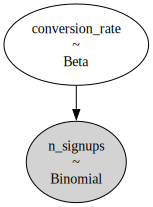

In [11]:
pm.model_to_graphviz(model)

First, let's draw a sample from the prior distribution.

In [12]:
with model:
    prior_samples = pm.sample_prior_predictive()

Sampling: [conversion_rate, n_signups]


Here's what it looks like.

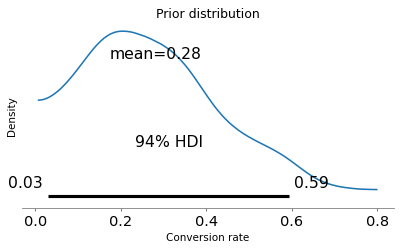

In [13]:
plot_prior(prior_samples)
plt.xlabel("Conversion rate")
plt.ylabel("Density")
plt.title("Prior distribution");

The result looks like the PDF of the beta distribution we computed.
The 94% HDI (highest density interval) shows the narrowest range of values that contain 94% of the probability.

Now let's sample from the posterior.

In [14]:
with model:
    trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Here's what the posterior distribution looks like.

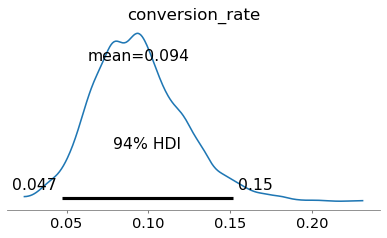

In [15]:
az.plot_posterior(trace);

The posterior distribution represents what we believe **after seeing the data**.
It's centered near the observed conversion rate, 8%.

The 94% HDI extends from 4.5% to 14%.
Which means there is a 94% chance that the true conversion rate falls in this range, subject to the assumptions of the model (for example that that rate does not change over time).

To compare the prior and posterior distributions, we'll combine `trace` and `prior_samples`.

In [16]:
with model:
    trace.extend(prior_samples)

And then we can use `plot_dist_comparison`.

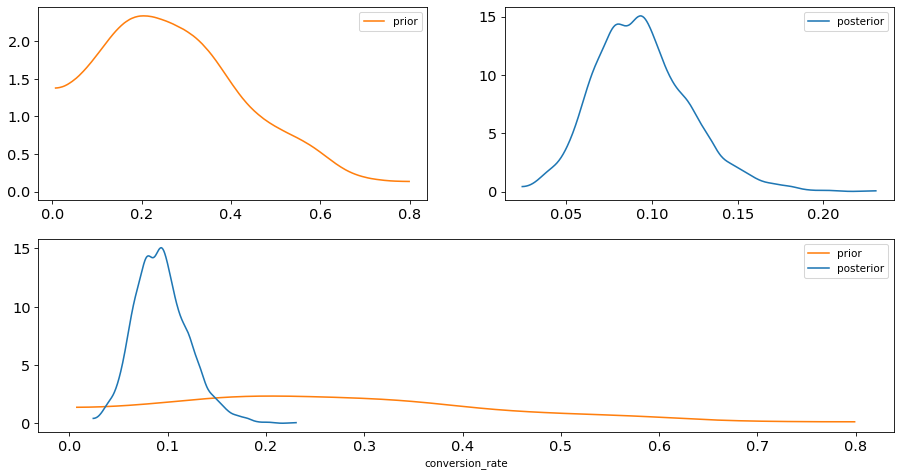

In [17]:
az.plot_dist_comparison(trace);

In summary:

* Prior distribution represents what we believe about the conversion rate before seeing the data.

* Posterior distribution represents what we believe about the conversion rate after seeing the data.

As we get more data, the posterior distribution gets narrower.

## What About That Prior?

The previous example uses a **weakly informative prior** -- based on what we know about email campaigns, we think the response rate could fall anywhere in a wide range.

Weakly informative priors "let the data speak for itself".

But when you have only a small dataset, the prior makes a big difference, so you should use as much information as you have.

Here's a problem that illustrates the point, from Chapter 4 of [Think Bayes](https://allendowney.github.io/ThinkBayes2/chap04.html#exercises) .

> In Major League Baseball, most players have a batting average between .210 and .320, which means that their probability of getting a hit is between 0.21 and 0.32.
>
>Suppose a player appearing in their first game gets 3 hits out of 3 attempts. What is the posterior distribution for their probability of getting a hit?

Here's a model that estimates a proportion after observing `k=3` successes out of `n=3` attempts.
It uses a weakly informative prior.

In [18]:
with pm.Model() as rookie_model:
    p = pm.Beta('p', alpha=2, beta=2)  
    obs = pm.Binomial('obs', n=3, p=p, observed=3)
    prior_trace = pm.sample_prior_predictive()
    trace = pm.sample()

Sampling: [obs, p]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Here's what that prior looks like .

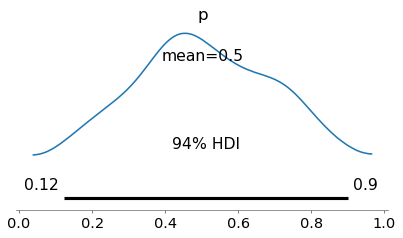

In [19]:
plot_prior(prior_trace);

Here's the posterior.

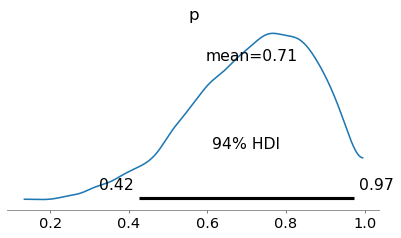

In [20]:
az.plot_posterior(trace, var_names=['p']);

In this case, "letting the data speak for itself" yields an unrealistic result.

We have a lot of information about batting averages in the major leagues, which we can use to choose a more reasonable prior.

We can specify the prior in terms of mean and dispersion, and convert to the parameters of the beta distribution.

In [21]:
mean = 0.250  # Mean batting average
std = 0.030  # Standard deviation

# Compute alpha and beta
alpha = mean * ((mean * (1 - mean)) / std**2 - 1)
beta = (1 - mean) * ((mean * (1 - mean)) / std**2 - 1)

alpha, beta

(51.833333333333336, 155.5)

Exercise: Go back and modify the prior of `rookie_model`.
Compute and plot the posterior mean, and see what effect the new prior has on the results.
Given what we know about the context, do the results seem more reasonable?

This example demonstrates the Bayesian version of [shrinkage](https://en.wikipedia.org/wiki/Shrinkage_(statistics)), so called because a estimate based on small data "shrinks" toward the prior mean.